# 입력과 정답 이미지 확인하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


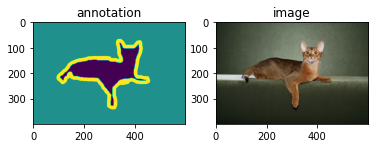

In [ ]:
import matplotlib.pyplot as plt

from PIL import Image

path_to_annotation = \
    "/content/drive/MyDrive/Colab Notebooks/data/CH07/CH07/annotations/trimaps"
path_to_image = \
    "/content/drive/MyDrive/Colab Notebooks/data/CH07/CH07/images"

annotation = Image.open(path_to_annotation + "/Abyssinian_1.png") # 이미지를 불러옴
plt.subplot(1, 2, 1)
plt.title("annotation")
plt.imshow(annotation)

image = Image.open(path_to_image + "/Abyssinian_1.jpg")
plt.subplot(1, 2, 2)
plt.title("image")
plt.imshow(image)

plt.show()

# 데이터셋 만들기

In [ ]:
import glob
import torch
import numpy as np

from torch.utils.data.dataset import Dataset
from PIL import Image


class Pets(Dataset):
   def __init__(self, path_to_img,
                path_to_anno,
                train=True,
                transforms=None,
                input_size=(128, 128)):

       # ❶ 정답과 입력 이미지를 이름순으로 정렬
       self.images = sorted(glob.glob(path_to_img+"/*.jpg"))
       self.annotations = sorted(glob.glob(path_to_anno + "/*.png"))


       # ❷ 데이터셋을 학습과 평가용으로 나눔
       self.X_train = self.images[:int(0.8 * len(self.images))]
       self.X_test = self.images[int(0.8 * len(self.images)):]
       self.Y_train = self.annotations[
                :int(0.8 * len(self.annotations))]
       self.Y_test = self.annotations[
                int(0.8 * len(self.annotations)):]

       self.train = train  # 학습용 데이터 평가용 데이터 결정 여부
       self.transforms = transforms  # 사용할 데이터 증강
       self.input_size = input_size  # 입력 이미지 크기
   def __len__(self):  # 데이터 개수를 나타냄
       if self.train:
           return len(self.X_train)  # 학습용 데이터셋 길이
       else:
           return len(self.X_test)   # 평가용 데이터셋 길이
   def preprocess_mask(self, mask):  # ➋ 정답을 변환해주는 함수
       mask = mask.resize(self.input_size)
       mask = np.array(mask).astype(np.float32)
       mask[mask != 2.0] = 1.0
       mask[mask == 2.0] = 0.0
       mask = torch.tensor(mask)
       return mask
   def __getitem__(self, i):  # i번째 데이터와 정답을 반환
       if self.train:  # 학습용 데이터
           X_train = Image.open(self.X_train[i])
           X_train = self.transforms(X_train)
           Y_train = Image.open(self.Y_train[i])
           Y_train = self.preprocess_mask(Y_train)

           return X_train, Y_train
       else:  # 평가용 데이터
           X_test = Image.open(self.X_test[i])
           X_test = self.transforms(X_test)
           Y_test = Image.open(self.Y_test[i])
           Y_test = self.preprocess_mask(Y_test)

           return X_test, Y_test

# U-Net 모델 정의하기

In [ ]:
import torch.nn as nn


class UNet(nn.Module):
   def __init__(self):
       super(UNet, self).__init__()
       # ❶ U-Net의 인코더에 사용되는 은닉층
       self.enc1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
       self.enc1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
       self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

       self.enc2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
       self.enc2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
       self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

       self.enc3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
       self.enc3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
       self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

       self.enc4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
       self.enc4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
       self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

       self.enc5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
       self.enc5_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
       # 디코더에 사용되는 은닉층
       self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
       self.dec4_1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
       self.dec4_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

       self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride=2)
       self.dec3_1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
       self.dec3_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

       self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride=2)
       self.dec2_1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
       self.dec2_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

       self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
       self.dec1_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
       self.dec1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
       self.dec1_3 = nn.Conv2d(64, 1, kernel_size=1)


       # 합성곱과 업샘플링층의 활성화 함수
       self.relu = nn.ReLU()
       # 출력층의 활성화함수
       self.sigmoid = nn.Sigmoid()
   def forward(self, x):
       x = self.enc1_1(x)
       x = self.relu(x)
       e1 = self.enc1_2(x)  # ❶ 디코더에서 사용하기 위해 따로 변수를 지정
       e1 = self.relu(e1)   # ❷ 합성곱층의 출력의 활성화
       x = self.pool1(e1)

       x = self.enc2_1(x)
       x = self.relu(x)
       e2 = self.enc2_2(x)
       e2 = self.relu(e2)
       x = self.pool2(e2)

       x = self.enc3_1(x)
       x = self.relu(x)
       e3 = self.enc3_2(x)
       e3 = self.relu(e3)
       x = self.pool3(e3)

       x = self.enc4_1(x)
       x = self.relu(x)
       e4 = self.enc4_2(x)
       e4 = self.relu(e4)
       x = self.pool4(e4)

       x = self.enc5_1(x)
       x = self.relu(x)
       x = self.enc5_2(x)
       x = self.relu(x)
       x = self.upsample4(x)

       # ❶ 인코더의 출력과 업샘플링된 이미지를 함침
       x = torch.cat([x, e4], dim=1)
       x = self.dec4_1(x)
       x = self.relu(x)
       x = self.dec4_2(x)
       x = self.relu(x)

       x = self.upsample3(x)
       x = torch.cat([x, e3], dim=1)
       x = self.dec3_1(x)
       x = self.relu(x)
       x = self.dec3_2(x)
       x = self.relu(x)

       x = self.upsample2(x)
       x = torch.cat([x, e2], dim=1)
       x = self.dec2_1(x)
       x = self.relu(x)
       x = self.dec2_2(x)
       x = self.relu(x)

       x = self.upsample1(x)
       x = torch.cat([x, e1], dim=1)
       x = self.dec1_1(x)
       x = self.relu(x)
       x = self.dec1_2(x)
       x = self.relu(x)
       x = self.dec1_3(x)

       x = torch.squeeze(x)  # ➋ 흑백 이미지를 그리기 위해 채널을 없앰

       return x

# 데이터 전처리 정의

In [ ]:
import tqdm

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor, Resize
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"


# 데이터 전처리 정의
transform = Compose([
   Resize((128, 128)),
   ToTensor()
])

# 데이터 불러오기

In [ ]:
# 학습 데이터
train_set = Pets(path_to_img=path_to_image,
                 path_to_anno=path_to_annotation,
                 transforms=transform)

# 평가용 데이터
test_set = Pets(path_to_img=path_to_image,
                path_to_anno=path_to_annotation,
                transforms=transform,
                train=False)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set)

# 학습에 필요한 요소 정의

In [ ]:
# 모델 정의
model = UNet().to(device)


# 학습률 정의
learning_rate = 0.0001

# 최적화 정의
optim = Adam(params=model.parameters(), lr=learning_rate)


# 학습 루프 정의

In [ ]:
for epoch in range(200):
   iterator = tqdm.tqdm(train_loader)

   for data, label in iterator:
       optim.zero_grad()  # 이전 루프의 기울기 초기화

       preds = model(data.to(device))  # 모델의 예측값 출력
       loss = nn.BCEWithLogitsLoss()(
           preds,
           label.type(torch.FloatTensor).to(device))  # 손실 계산
       loss.backward()  # 오차 역전파

       optim.step()  # 최적화

       iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "./UNet.pth")  # 모델 가중치 저장

epoch24 loss:0.1466335952281952:  42%|████▏     | 78/185 [00:48<01:04,  1.66it/s] 

# 모델 성능 평가

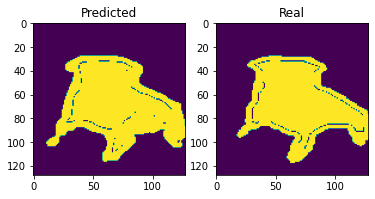

In [ ]:
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("./UNet.pth", map_location="cpu"))
data, label = test_set[1]
pred = model(torch.unsqueeze(data.to(device), dim=0))>0.5  # ❶ 픽셀을 이진 분류함

with torch.no_grad():
   plt.subplot(1, 2, 1)
   plt.title("Predicted")
   plt.imshow(pred)
   plt.subplot(1, 2, 2)
   plt.title("Real")
   plt.imshow(label)
   plt.show()